# SEMPRE 50th Anniversary Conference
![Sempre Logo](https://sempre.org.uk/images/sempre50th.jpg)
## Video Figures

The figures created in this notebook were used in a video presentation given at the [SEMPRE 50th Anniversary Conference](https://sempre.org.uk/50th), Senate House, University of London, 2-3rd September 2022. The title of the presentation was "Measuring the effects of variable latency timings and jitter on networked music performances".

You can watch the full 10-minute video presentation [on YouTube](https://www.youtube.com/watch?v=x2kRgIk0bcw) or embedded below:

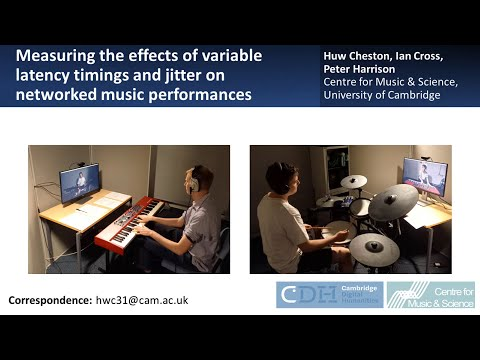

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("x2kRgIk0bcw")

## 1. Load dependencies, set constants

In [2]:
!git clone https://github.com/HuwCheston/Jazz-Jitter-Analysis

Cloning into 'Jazz-Jitter-Analysis'...
remote: Enumerating objects: 1580, done.
remote: Counting objects: 100% (414/414), done.
remote: Compressing objects: 100% (279/279), done.
remote: Total 1580 (delta 223), reused 313 (delta 128), pack-reused 1166
Receiving objects: 100% (1580/1580), 8.86 MiB | 12.47 MiB/s, done.
Resolving deltas: 100% (896/896), done.


In [3]:
!pip install dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 1.9 MB/s eta 0:00:00


In [4]:
import os
import sys
import dill
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
from scipy.signal import savgol_filter

In [5]:
sys.path.append(os.path.abspath("/content/Jazz-Jitter-Analysis"))
print(sys.path)

['/content', '/env/python', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.9/dist-packages/IPython/extensions', '/root/.ipython', '/content/Jazz-Jitter-Analysis']


## 2. Load pre-processed data
We load pre-processed MIDI data from two performances, one which slowed down and another which sped up.

In [6]:
input_filepath = "/content/Jazz-Jitter-Analysis/notebooks/sempre_graph_examples/sempre_graph_examples.p"
figures_filepath = "/content/Jazz-Jitter-Analysis/reports/figures"

In [7]:
data = dill.load(open(input_filepath, "rb"))

## 3. Clean loaded data

In [8]:
# Define variables to be assigned later
decelerating_perf_k = None
decelerating_perf_d = None
accelerating_perf_k = None
accelerating_perf_d = None

In [9]:
col = ['onset', 'pitch', 'velocity']
def format_loaded_data(arr) -> pd.DataFrame:
    """Formats loaded dataframe, generates BPMs with rolling window"""
    # Load dataframe, drop unnecessary columns
    df = pd.DataFrame(arr, columns=col).drop(['pitch', 'velocity'], axis=1)
    # Extract IOI
    df['ioi'] = df['onset'].diff()
    df['onset_floor'] = np.floor(df['onset'])
    return df

In [10]:
# Iterate through each condition in trial
for con in data:
    # Decelerating performance
    if con['trial'] == 4 and con['block'] == 1 and con['latency'] == 45 and con['jitter'] == 1:
        if con['instrument'] == 'Drums':
            decelerating_perf_d = format_loaded_data(con['midi_bpm'])
        elif con['instrument'] == 'Keys':
            decelerating_perf_k = format_loaded_data(con['midi_bpm'])
    # Accelerating performance
    elif con['trial'] == 5 and con['block'] == 1 and con['latency'] == 180 and con['jitter'] == 1:
        if con['instrument'] == 'Drums':
            accelerating_perf_d = format_loaded_data(con['midi_bpm'])
        elif con['instrument'] == 'Keys':
            accelerating_perf_k = format_loaded_data(con['midi_bpm'])

In [11]:
def average_perf(df1, df2) -> list:
    """
    Returns a list of averaged BPMs from two performance.
    Data is grouped by every second in a performance.
    """
    # Merge dataframes from both performers together
    bigdf = df1.merge(df2, how='inner', on='onset_floor')
    # Set function
    fn = lambda g: g.drop_duplicates().dropna().tolist()
    # Average tempo of beat onsets created by both musicians within one second
    avg_tempo = [(idx, np.mean([*fn(60/grp['ioi_x']), *fn(60/grp['ioi_y'])])) for idx, grp in bigdf.groupby('onset_floor')]
    # Create dataframe
    processed_df = pd.DataFrame(avg_tempo, columns=['onset', 'bpm_avg'])
    # Roll average BPM column
    processed_df['bpm_rolling'] = processed_df['bpm_avg'].rolling(window=4).mean()
    return processed_df

In [12]:
decelerating_df = average_perf(decelerating_perf_d, decelerating_perf_k)
accelerating_df = average_perf(accelerating_perf_d, accelerating_perf_k)

## 4. Create graphs

In [13]:
# Set options in matplotlib
plt.rcParams.update({
    'font.size': 45,
    "font.family": "sans",
    'legend.fontsize': 'x-large',
    'figure.figsize': (30, 14),
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'lines.linewidth': 10,
    'lines.markersize': 10,
    'ytick.major.size': 30.0,
    'xtick.major.size': 30.0,
})

(array([ 20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120'),
  Text(0, 140.0, '140')])

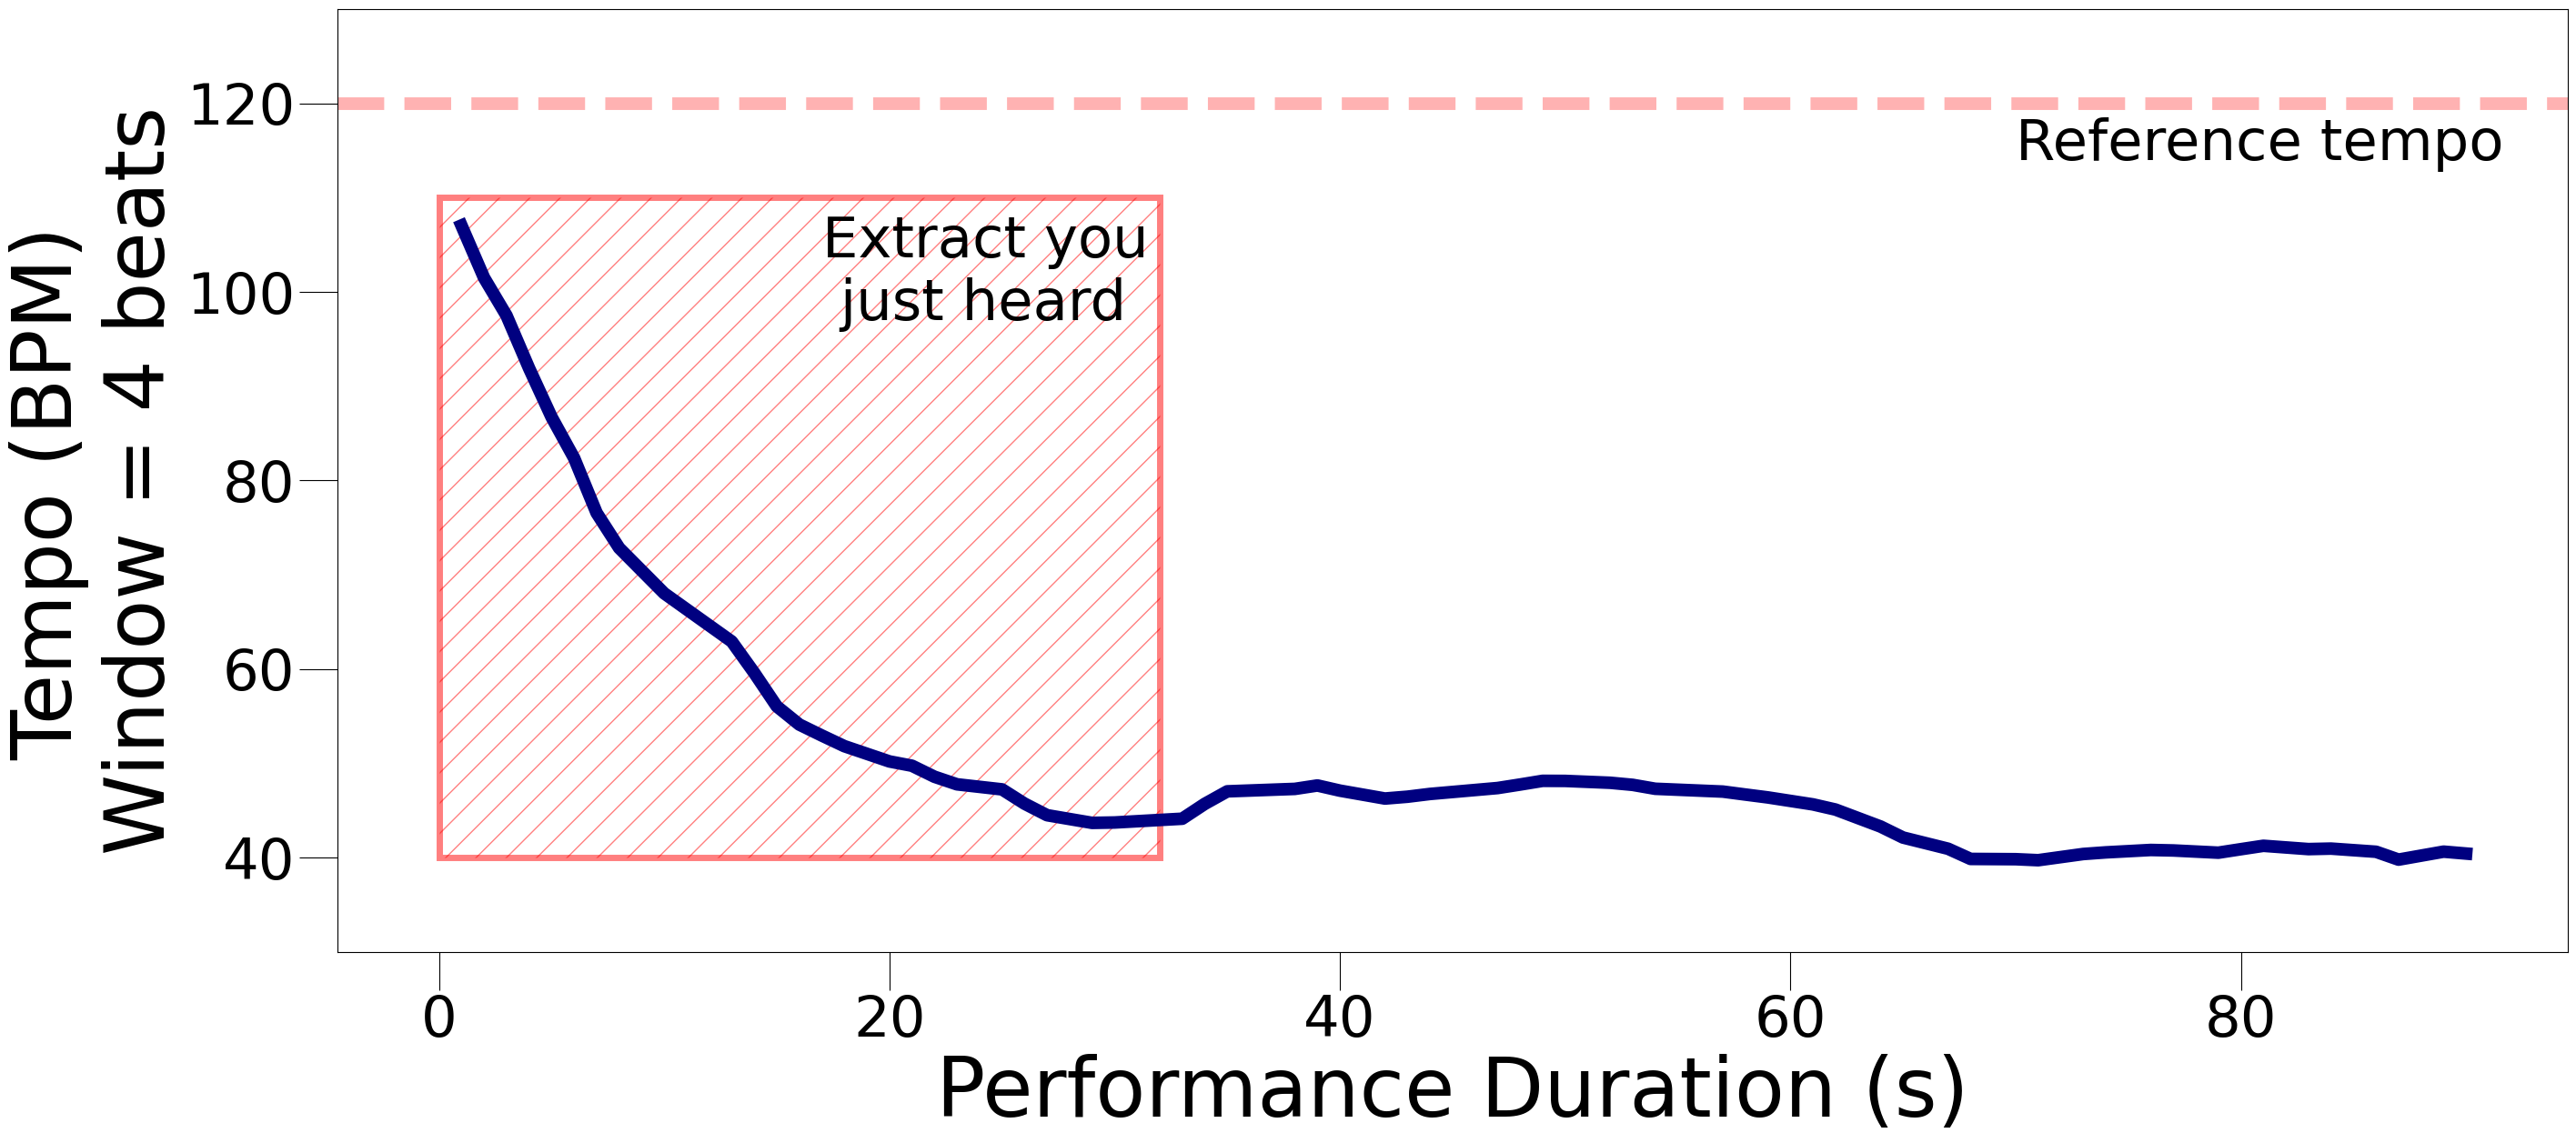

In [14]:
# Create subplots
fig, ax = plt.subplots(1, 1)
# Plot tempo graph
ax.plot(decelerating_df['onset'] - 10, decelerating_df['bpm_rolling'], color='#000080')
# Add rectangle showing excerpt
ax.add_patch(
     matplotlib.patches.Rectangle(
         (0, 40),
         height=70,
         width=32,
         fill=False,
         color='red',
         hatch='/',
         linewidth=5.0,
         capstyle='butt',
         alpha=0.5,
     )
)
# Add horizontal line showing reference tempo
ax.axhline(y=120, color='r', linestyle='--', alpha=0.3)
# Set titles, labels, axis limits
ax.set_ylabel('Tempo (BPM) \nWindow = 4 beats')
ax.set_xlabel('Performance Duration (s)')
ax.set_ylim((30, 130))
ax.annotate("Reference tempo", xy=(80, 120), xytext=(70, 114),)
ax.annotate("Extract you \n just heard", xy=(15, 100), xytext=(17, 97),)
plt.tight_layout()

plt.xticks(fontsize=45,)
plt.yticks(fontsize=45,)

# Remove comment to save figure
# fig.savefig(f'{figures_filepath}\\sempre_presentation_graphs\\sempre_graphs_decelerating_performance.png', facecolor='white', transparent=False)

(array([110., 120., 130., 140., 150.]),
 [Text(0, 110.0, '110'),
  Text(0, 120.0, '120'),
  Text(0, 130.0, '130'),
  Text(0, 140.0, '140'),
  Text(0, 150.0, '150')])

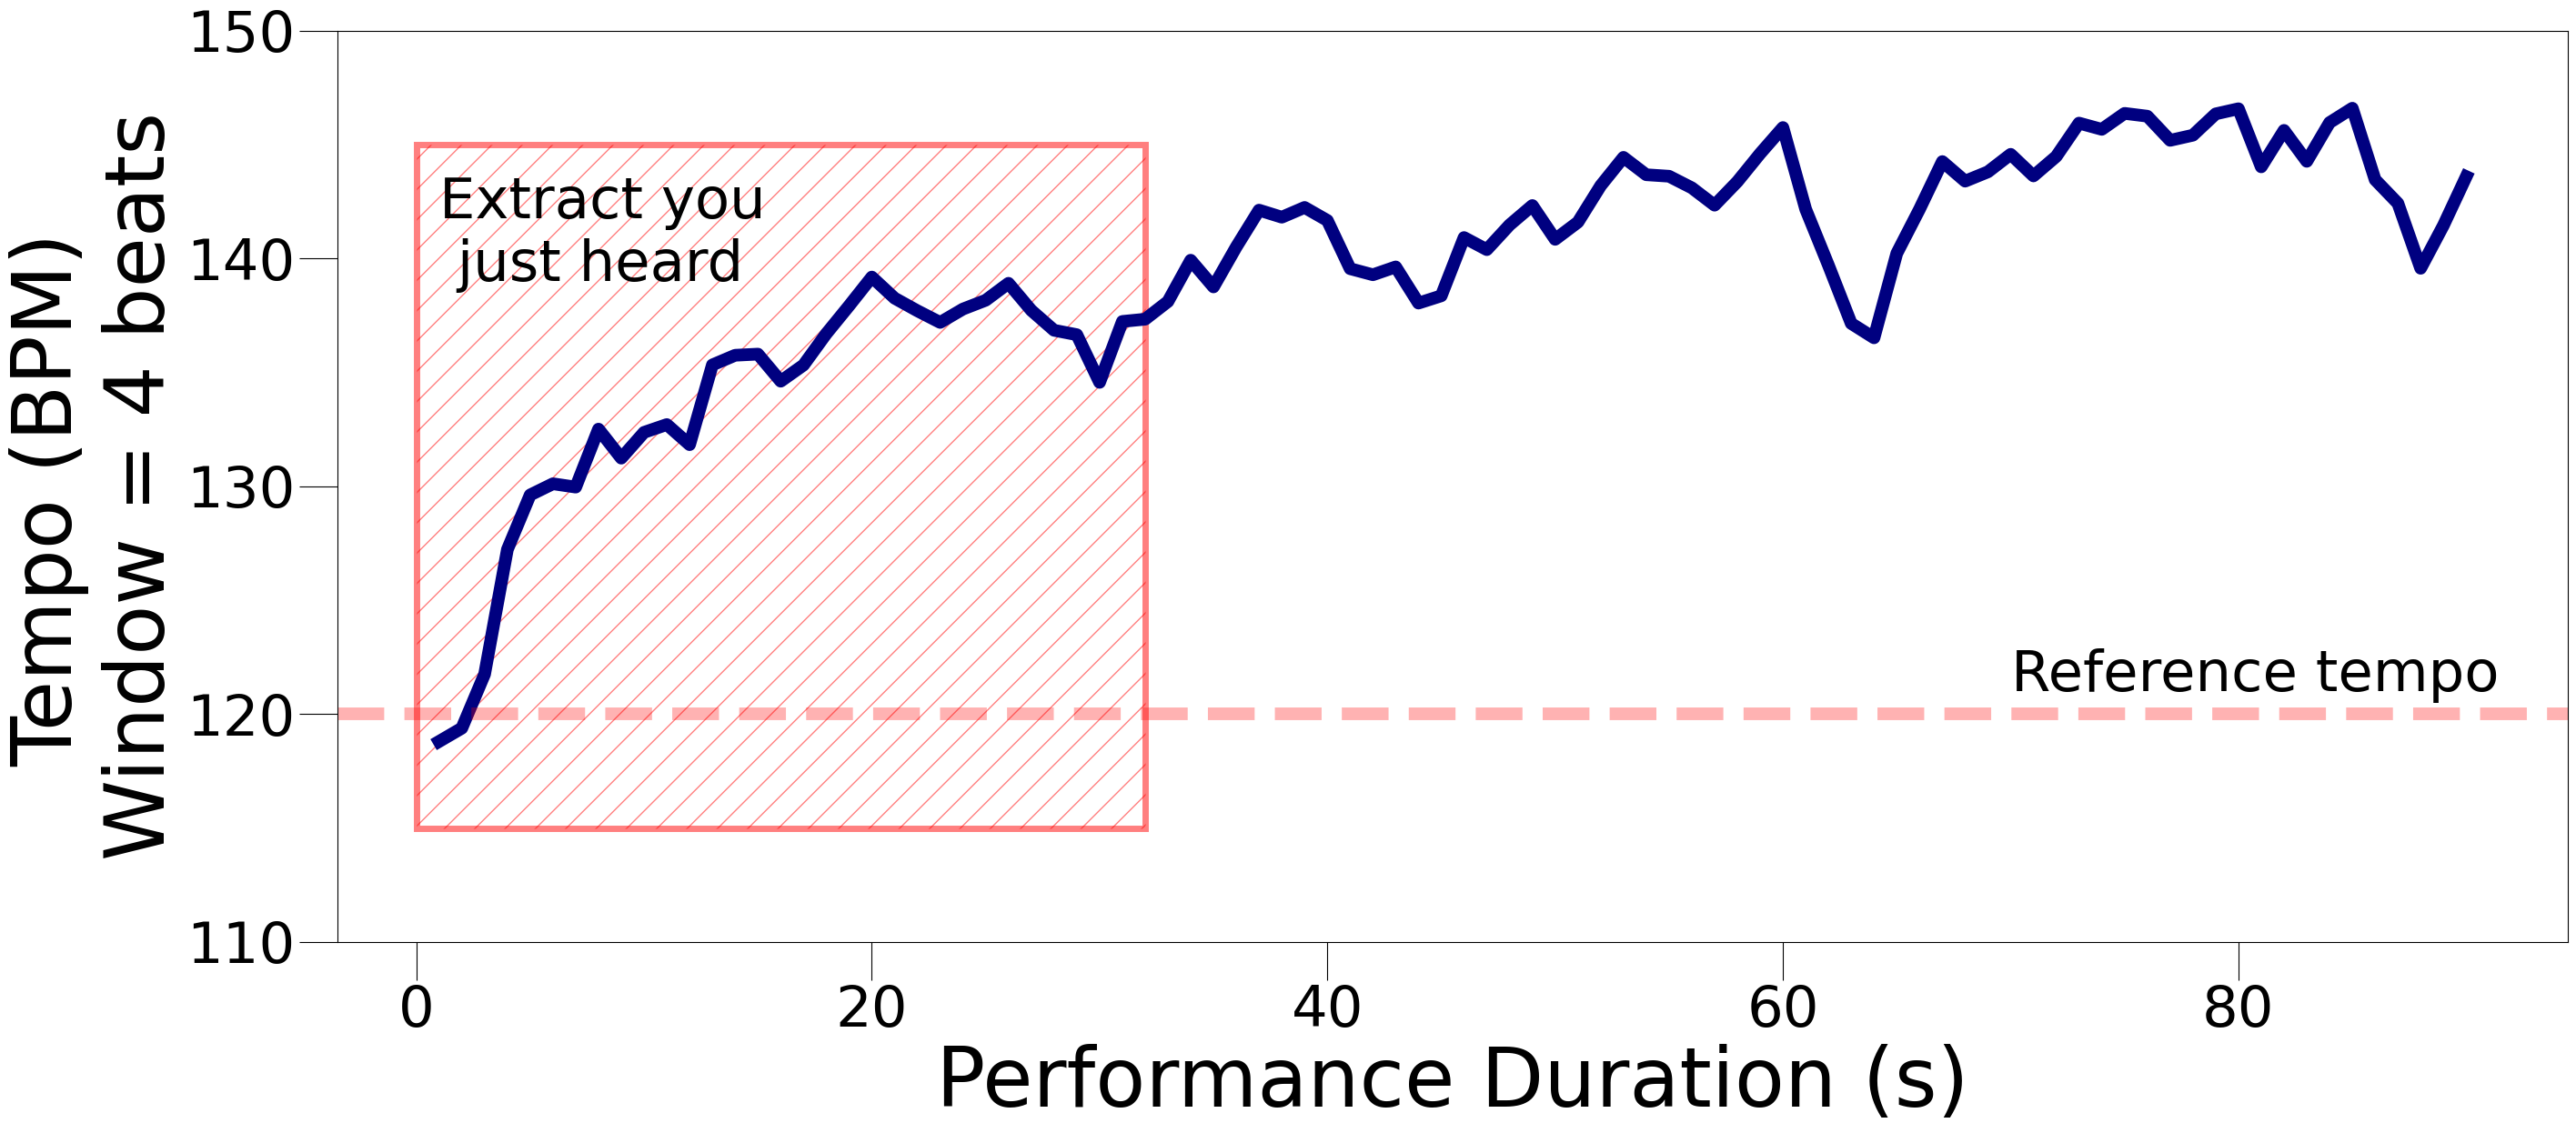

In [15]:
fig, ax = plt.subplots(1, 1)
ax.plot(accelerating_df['onset'] - 10, accelerating_df['bpm_rolling'], color='#000080')
ax.set_ylabel('Tempo (BPM) \nWindow = 4 beats')
ax.set_xlabel('Performance Duration (s)')
ax.set_ylim((110, 150))
ax.add_patch(
     matplotlib.patches.Rectangle(
         (0, 115),
         height=30,
         width=32,
         fill=False,
         color='red',
         hatch='/',
         linewidth=5.0,
         capstyle='butt',
         alpha=0.5,
     )
)
ax.axhline(y=120, color='r', linestyle='--', alpha=0.3)
ax.annotate("Extract you \n just heard", xy=(30, 120), xytext=(1, 139),)
ax.annotate("Reference tempo", xy=(80, 120), xytext=(70, 121),)
plt.tight_layout()

plt.xticks(fontsize=45,)
plt.yticks(fontsize=45,)

# Remove comment to save figure
# fig.savefig(f'{figures_filepath}\\sempre_presentation_graphs\\sempre_graphs_accelerating_performance.png', facecolor='white', transparent=False)